# Install necessary packages

We can install the necessary packages by either running `pip install --user <package_name>` or include everything in a `requirements.txt` file and run `pip install --user -r requirements.txt`.

> NOTE: Do not forget to use the `--user` argument. It is necessary if you want to use Kale to transform this notebook into a Kubeflow pipeline

In [1]:
!pip3 install --user -r requirements.txt

# Imports

In this section we import the packages we need for this example. Make it a habbit to gather your imports in a single place. It will make your life easier if you are going to transform this notebook into a Kubeflow pipeline using Kale.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms

In [3]:
assert torch.__version__ <= "1.5.0"

# Project hyper-parameters

In this cell, we define the different hyper-parameters variables. Defining them in one place makes it easier to experiment with their values and also facilitates the execution of HP Tuning experiments using Kale and Katib.

In [4]:
LR = 1e-3
BATCH_SIZE = 500
EPOCHS = 1

# Load and preprocess data

In this section, we load and process the dataset to get it in a ready-to-use form by the model.

In [5]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [6]:
x_trn = datasets.MNIST('data', train=True, transform=transform, download=True)
x_tst = datasets.MNIST('data', train=False, transform=transform)

In [7]:
trn_loader = torch.utils.data.DataLoader(x_trn, batch_size=BATCH_SIZE)
tst_loader = torch.utils.data.DataLoader(x_tst, batch_size=BATCH_SIZE)

# Define and train the model

We are now ready to define our model. In this example, we define a custom CNN architecture, using a simple PyTorch `nn.Module`.

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.dropout2(x)
        x = self.fc2(x)
        
        output = F.log_softmax(x, dim=1)
        return output

In [9]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=LR)

In the following cell, we define the training loop and the logging statements to monitor the performance of the model

In [10]:
log_interval = 40
model.train()

for epoch in range(1, EPOCHS + 1):
    for idx, (data, target) in enumerate(trn_loader):
        data, target = data, target
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{idx * len(data)}/{len(trn_loader.dataset)}"
                  f" ({100. * idx / len(trn_loader):.0f}%)]\tLoss: {loss.item():.6f}")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.313139
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.303629
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.143604


In [12]:
torch.save(model.state_dict(), "model.pt")

# Evaluate the model

Finally, we are ready to evaluate the model using the test set. Below is a python loop that does exactly that.

In [13]:
tst_loss = 0
correct = 0
model.eval()

with torch.no_grad():
    for data, target in tst_loader:
        data, target = data, target
        output = model(data)
        tst_loss += F.nll_loss(output, target, reduction='sum').item() 
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        
tst_loss /= len(tst_loader.dataset)

print(f"\nTest set: Average loss: {tst_loss:.4f},"
      f" Accuracy: {correct}/{len(tst_loader.dataset)}"
      f" ({100. * correct / len(tst_loader.dataset):.0f}%)\n")


Test set: Average loss: 0.0685, Accuracy: 9773/10000 (98%)



# Serving

We can deploy the model and use it just like any other web service using KFServing. All we need is to create the necessary configuration file. Take a look in the `torch.yaml` file. We need to specify a `pytorch` predictor and make the `storageUri` parameter point to the location where the `.pt` model file is stored. Also, we need the actual model architecture, defined in a `.py` file.

In [14]:
!kubectl apply -f torch.yaml

inferenceservice.serving.kubeflow.org/pytorch-mnist created


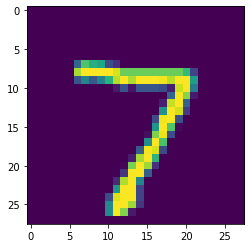

In [18]:
import numpy as np
import matplotlib.pyplot as plt


# get an image example
example_tensor = next(iter(tst_loader))[0][0]
# transform it into a list
example_img = example_tensor.numpy().tolist()
# visualize
plt.imshow(np.array(example_img).transpose(1,2,0))
plt.show()

Now we can make a request to the server and check the results.

In [19]:
import requests

data = {
    "instances": [example_img]
}

headers = {"content-type": "application/json", "Host": "pytorch-mnist.kubeflow-user.svc.cluster.local"}
response = requests.post("http://cluster-local-gateway.istio-system/v1/models/pytorch-mnist:predict", json=data, headers=headers)

In [20]:
import json

response
torch.argmax(torch.Tensor(np.array(json.loads(response.text)["predictions"])))

tensor(7)